In [ ]:


import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange

matplotlib.use('Agg')


class Bandit:
    # @k_arm: # of arms
    # @epsilon: probability for exploration in epsilon-greedy algorithm
    # @initial: initial estimation for each action
    # @step_size: constant step size for updating estimations
    # @sample_averages: if True, use sample averages to update estimations instead of constant step size
    # @UCB_param: if not None, use UCB algorithm to select action
    # @gradient: if True, use gradient based bandit algorithm
    # @gradient_baseline: if True, use average reward as baseline for gradient based bandit algorithm
    def __init__(self, k_arm=10, epsilon=0., initial=0., step_size=0.1, sample_averages=False, UCB_param=None,
                 gradient=False, gradient_baseline=False, true_reward=0.):
        self.k = k_arm
        self.step_size = step_size
        self.sample_averages = sample_averages
        self.indices = np.arange(self.k)
        self.time = 0
        self.UCB_param = UCB_param
        self.gradient = gradient
        self.gradient_baseline = gradient_baseline
        self.average_reward = 0
        self.true_reward = true_reward
        self.epsilon = epsilon
        self.initial = initial

    def reset(self):
        # real reward for each action
        self.q_true = np.random.randn(self.k) + self.true_reward

        # estimation for each action
        self.q_estimation = np.zeros(self.k) + self.initial

        # # of chosen times for each action
        self.action_count = np.zeros(self.k)

        self.best_action = np.argmax(self.q_true)

        self.time = 0

    # get an action for this bandit
    def act(self):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.indices)

        if self.UCB_param is not None:
            UCB_estimation = self.q_estimation + \
                self.UCB_param * np.sqrt(np.log(self.time + 1) / (self.action_count + 1e-5))
            q_best = np.max(UCB_estimation)
            return np.random.choice(np.where(UCB_estimation == q_best)[0])

        if self.gradient:
            exp_est = np.exp(self.q_estimation)
            self.action_prob = exp_est / np.sum(exp_est)
            return np.random.choice(self.indices, p=self.action_prob)

        q_best = np.max(self.q_estimation)
        return np.random.choice(np.where(self.q_estimation == q_best)[0])

    # take an action, update estimation for this action
    def step(self, action):
        # generate the reward under N(real reward, 1)
        reward = np.random.randn() + self.q_true[action]
        self.time += 1
        self.action_count[action] += 1
        self.average_reward += (reward - self.average_reward) / self.time

        if self.sample_averages:
            # update estimation using sample averages
            self.q_estimation[action] += (reward - self.q_estimation[action]) / self.action_count[action]
        elif self.gradient:
            one_hot = np.zeros(self.k)
            one_hot[action] = 1
            if self.gradient_baseline:
                baseline = self.average_reward
            else:
                baseline = 0
            self.q_estimation += self.step_size * (reward - baseline) * (one_hot - self.action_prob)
        else:
            # update estimation with constant step size
            self.q_estimation[action] += self.step_size * (reward - self.q_estimation[action])
        return reward


def simulate(runs, time, bandits):
    rewards = np.zeros((len(bandits), runs, time))
    best_action_counts = np.zeros(rewards.shape)
    for i, bandit in enumerate(bandits):
        for r in trange(runs):
            bandit.reset()
            for t in range(time):
                action = bandit.act()
                reward = bandit.step(action)
                rewards[i, r, t] = reward
                if action == bandit.best_action:
                    best_action_counts[i, r, t] = 1
    mean_best_action_counts = best_action_counts.mean(axis=1)
    mean_rewards = rewards.mean(axis=1)
    return mean_best_action_counts, mean_rewards


def figure_2_1():
    plt.violinplot(dataset=np.random.randn(200, 10) + np.random.randn(10))
    plt.xlabel("Action")
    plt.ylabel("Reward distribution")
    plt.savefig('/content/drive/MyDrive/Colab Notebooks/RL/Images/figure_2_1.png')
    plt.close()


def figure_2_2(runs=2000, time=1500):
    epsilons = [0, 0.1, 0.01]
    bandits = [Bandit(epsilon=eps, sample_averages=True) for eps in epsilons]
    best_action_counts, rewards = simulate(runs, time, bandits)

    plt.figure(figsize=(10, 20))

    plt.subplot(2, 1, 1)
    for eps, rewards in zip(epsilons, rewards):
        plt.plot(rewards, label='$\epsilon = %.02f$' % (eps))
    plt.xlabel('steps')
    plt.ylabel('average reward')
    plt.legend()

    plt.subplot(2, 1, 2)
    for eps, counts in zip(epsilons, best_action_counts):
        plt.plot(counts, label='$\epsilon = %.02f$' % (eps))
    plt.xlabel('steps')
    plt.ylabel('% optimal action')
    plt.legend()

    plt.savefig('/content/drive/MyDrive/Colab Notebooks/RL/Images/figure_2_2.png')
    plt.close()


def figure_2_3(runs=2000, time=1000):
    bandits = []
    bandits.append(Bandit(epsilon=0, initial=5, step_size=0.1))
    bandits.append(Bandit(epsilon=0.1, initial=0, step_size=0.1))
    best_action_counts, _ = simulate(runs, time, bandits)

    plt.plot(best_action_counts[0], label='$\epsilon = 0, q = 5$')
    plt.plot(best_action_counts[1], label='$\epsilon = 0.1, q = 0$')
    plt.xlabel('Steps')
    plt.ylabel('% optimal action')
    plt.legend()

    plt.savefig('/content/drive/MyDrive/Colab Notebooks/RL/Images/figure_2_3.png')
    plt.close()


def figure_2_4(runs=2000, time=1000):
    bandits = []
    bandits.append(Bandit(epsilon=0, UCB_param=2, sample_averages=True))
    bandits.append(Bandit(epsilon=0.1, sample_averages=True))
    _, average_rewards = simulate(runs, time, bandits)

    plt.plot(average_rewards[0], label='UCB $c = 2$')
    plt.plot(average_rewards[1], label='epsilon greedy $\epsilon = 0.1$')
    plt.xlabel('Steps')
    plt.ylabel('Average reward')
    plt.legend()

    plt.savefig('/content/drive/MyDrive/Colab Notebooks/RL/Images/figure_2_4.png')
    plt.close()


def figure_2_5(runs=2000, time=1000):
    bandits = []
    bandits.append(Bandit(gradient=True, step_size=0.1, gradient_baseline=True, true_reward=4))
    bandits.append(Bandit(gradient=True, step_size=0.1, gradient_baseline=False, true_reward=4))
    bandits.append(Bandit(gradient=True, step_size=0.4, gradient_baseline=True, true_reward=4))
    bandits.append(Bandit(gradient=True, step_size=0.4, gradient_baseline=False, true_reward=4))
    best_action_counts, _ = simulate(runs, time, bandits)
    labels = [r'$\alpha = 0.1$, with baseline',
              r'$\alpha = 0.1$, without baseline',
              r'$\alpha = 0.4$, with baseline',
              r'$\alpha = 0.4$, without baseline']

    for i in range(len(bandits)):
        plt.plot(best_action_counts[i], label=labels[i])
    plt.xlabel('Steps')
    plt.ylabel('% Optimal action')
    plt.legend()

    plt.savefig('/content/drive/MyDrive/Colab Notebooks/RL/Images/figure_2_5.png')
    plt.close()


def figure_2_6(runs=2000, time=1000):
    labels = ['epsilon-greedy', 'gradient bandit',
              'UCB', 'optimistic initialization']
    generators = [lambda epsilon: Bandit(epsilon=epsilon, sample_averages=True),
                  lambda alpha: Bandit(gradient=True, step_size=alpha, gradient_baseline=True),
                  lambda coef: Bandit(epsilon=0, UCB_param=coef, sample_averages=True),
                  lambda initial: Bandit(epsilon=0, initial=initial, step_size=0.1)]
    parameters = [np.arange(-7, -1, dtype=np.float),
                  np.arange(-5, 2, dtype=np.float),
                  np.arange(-4, 3, dtype=np.float),
                  np.arange(-2, 3, dtype=np.float)]

    bandits = []
    for generator, parameter in zip(generators, parameters):
        for param in parameter:
            bandits.append(generator(pow(2, param)))

    _, average_rewards = simulate(runs, time, bandits)
    rewards = np.mean(average_rewards, axis=1)

    i = 0
    for label, parameter in zip(labels, parameters):
        l = len(parameter)
        plt.plot(parameter, rewards[i:i+l], label=label)
        i += l
    plt.xlabel('Parameter($2^x$)')
    plt.ylabel('Average reward')
    plt.legend()

    plt.savefig('/content/drive/MyDrive/Colab Notebooks/RL/Images/figure_2_6.png')
    plt.close()


if __name__ == '__main__':
    figure_2_1()
    figure_2_2()
    figure_2_3()
    figure_2_4()
    figure_2_5()
    figure_2_6()

100%|██████████| 2000/2000 [02:26<00:00, 13.61it/s]
<ipython-input-1-58f5052423ba>:212: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  parameters = [np.arange(-7, -1, dtype=np.float),
<ipython-input-1-58f5052423ba>:213: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.arange(-5, 2, dtype=np.float),
<ipython-input-1-58f5052423ba>:214: Depre

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

dataset1=np.random.randn(2000, 10)
dataset2 = dataset1 + np.random.randn(10)

{'bodies': [<matplotlib.collections.PolyCollection at 0x7dccd200d570>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x7dccd200d540>,
 'cmins': <matplotlib.collections.LineCollection at 0x7dccd200fbb0>,
 'cbars': <matplotlib.collections.LineCollection at 0x7dccd2054100>}

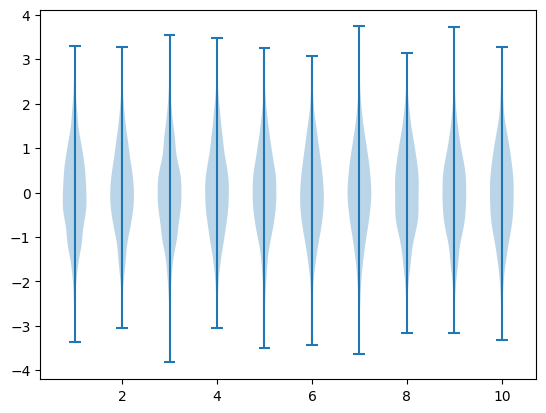

In [ ]:
#print(dataset)
plt.violinplot(dataset1)

{'bodies': [<matplotlib.collections.PolyCollection at 0x7dccd1eb2410>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x7dccd1eb2350>,
 'cmins': <matplotlib.collections.LineCollection at 0x7dccd1ef4a30>,
 'cbars': <matplotlib.collections.LineCollection at 0x7dccd1ef4f40>}

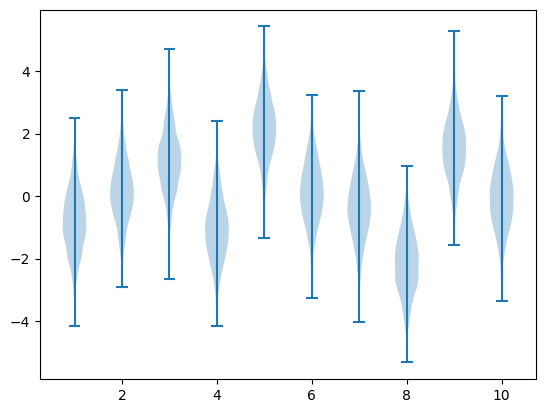

In [ ]:
plt.violinplot(dataset2)

(array([[  1.,  19., 102., 325., 538., 552., 321., 113.,  26.,   3.],
        [  0.,  20.,  99., 270., 571., 582., 317., 117.,  20.,   4.],
        [  1.,  13.,  99., 327., 564., 562., 302., 112.,  16.,   4.],
        [  0.,  26.,  91., 310., 534., 560., 313., 138.,  25.,   3.],
        [  1.,  20., 101., 274., 560., 583., 332., 112.,  15.,   2.],
        [  2.,  22.,  96., 313., 559., 534., 335., 110.,  28.,   1.],
        [  5.,  25., 102., 293., 533., 567., 333., 125.,  13.,   4.],
        [  3.,  20., 105., 285., 548., 549., 343., 124.,  20.,   3.],
        [  1.,  12., 110., 298., 573., 572., 313., 101.,  16.,   4.],
        [  4.,  26.,  99., 323., 542., 547., 336., 103.,  17.,   3.]]),
 array([-3.8243652 , -3.06804631, -2.31172742, -1.55540854, -0.79908965,
        -0.04277076,  0.71354813,  1.46986702,  2.22618591,  2.98250479,
         3.73882368]),
 <a list of 10 BarContainer objects>)

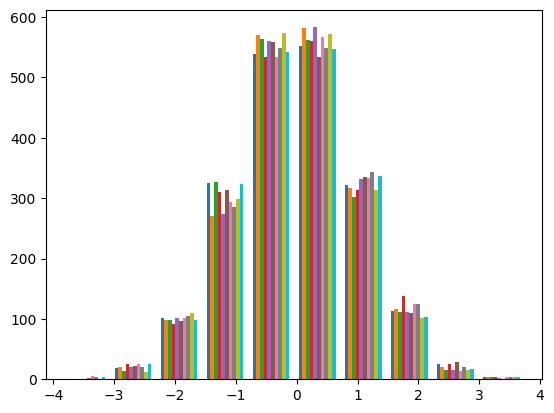

In [ ]:
plt.hist(dataset1)

(array([[  0.,  15., 173., 657., 768., 329.,  55.,   3.,   0.,   0.],
        [  0.,   0.,  21., 214., 698., 746., 290.,  30.,   1.,   0.],
        [  0.,   0.,   1.,  21., 238., 744., 696., 270.,  29.,   1.],
        [  0.,  42., 268., 731., 676., 255.,  27.,   1.,   0.,   0.],
        [  0.,   0.,   0.,   1.,  34., 239., 746., 721., 240.,  19.],
        [  0.,   1.,  29., 204., 714., 717., 290.,  45.,   0.,   0.],
        [  0.,  10.,  92., 420., 799., 550., 120.,   8.,   1.,   0.],
        [ 42., 261., 736., 696., 242.,  23.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   5., 135., 543., 827., 415.,  69.,   6.],
        [  0.,   4.,  47., 297., 755., 674., 204.,  19.,   0.,   0.]]),
 array([-5.32760248, -4.25153808, -3.17547368, -2.09940928, -1.02334488,
         0.05271953,  1.12878393,  2.20484833,  3.28091273,  4.35697713,
         5.43304153]),
 <a list of 10 BarContainer objects>)

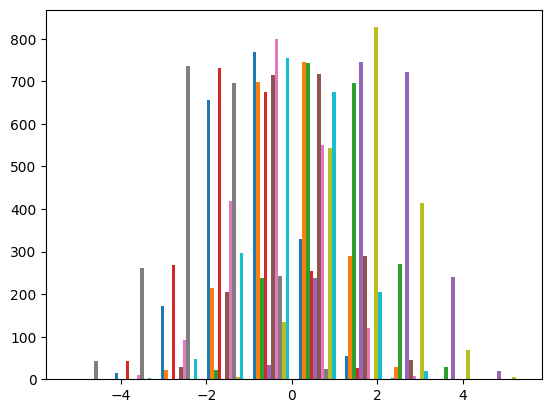

In [ ]:
plt.hist(dataset2)